In [1]:

# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)


In [2]:
df = pd.read_csv("E:/DataScienceProject/Data/application_record.csv")
df_clean = df.copy()

In [3]:
#Quick check of data types & missing values
df_clean.info()
df_clean.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [4]:
#Convert DAYS_BIRTH → AGE
df_clean["AGE"] = (-df_clean["DAYS_BIRTH"] / 365.25).astype(int)

df_clean.drop(columns=["DAYS_BIRTH"], inplace=True)


In [5]:
#Fix DAYS_EMPLOYED outliers → EMP_YEARS
df_clean["DAYS_EMPLOYED"] = df_clean["DAYS_EMPLOYED"].replace(365243, np.nan)

df_clean["EMP_YEARS"] = (-df_clean["DAYS_EMPLOYED"] / 365.25).round(1)

df_clean.drop(columns=["DAYS_EMPLOYED"], inplace=True)


In [6]:
df_clean.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,EMP_YEARS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,32,12.4
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,32,12.4
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,58,3.1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8.4
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8.4


In [7]:
#Fix missing values in OCCUPATION_TYPE
df_clean["OCCUPATION_TYPE"].fillna("Unknown", inplace=True)


In [8]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  FLAG_MOBIL           438557 non-null  int64  
 11  FLAG_WORK_PHONE      438557 non-null  int64  
 12  FLAG_PHONE           438557 non-null  int64  
 13  FLAG_EMAIL           438557 non-null  int64  
 14  OCCUPATION_TYPE      438557 non-null  object 
 15  CNT_FAM_MEMBERS  

In [9]:
#Replace NaN with 0 for EMP_YEARS 
df_clean["EMP_YEARS"].fillna(0, inplace=True)


In [10]:
#Create new useful features (for clustering) Income per family member
df_clean["INCOME_PER_MEMBER"] = (
    df_clean["AMT_INCOME_TOTAL"] / df_clean["CNT_FAM_MEMBERS"]
)


In [11]:
#Create new useful features (for clustering) Child Ratio
df_clean["CHILD_RATIO"] = (
    df_clean["CNT_CHILDREN"] / df_clean["CNT_FAM_MEMBERS"]
)


In [12]:
#Drop ID (not useful for clustering)
df_clean.drop(columns=["ID"], inplace=True)

In [13]:
#Identify categorical vs numeric columns
cat_cols = df_clean.select_dtypes(include=["object"]).columns
num_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns

print("Categorical:", cat_cols)
print("Numeric:", num_cols)


Categorical: Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE'],
      dtype='object')
Numeric: Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'AGE', 'EMP_YEARS',
       'INCOME_PER_MEMBER', 'CHILD_RATIO'],
      dtype='object')


In [14]:
#One-Hot Encode Categorical Variables
df_clean= pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)


In [15]:
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 49 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   CNT_CHILDREN                                       438557 non-null  int64  
 1   AMT_INCOME_TOTAL                                   438557 non-null  float64
 2   FLAG_MOBIL                                         438557 non-null  int64  
 3   FLAG_WORK_PHONE                                    438557 non-null  int64  
 4   FLAG_PHONE                                         438557 non-null  int64  
 5   FLAG_EMAIL                                         438557 non-null  int64  
 6   CNT_FAM_MEMBERS                                    438557 non-null  float64
 7   AGE                                                438557 non-null  int64  
 8   EMP_YEARS                                          438557 non-null  float6

In [16]:
#Convert all the 38 boolean columns to integers
bool_cols = df_clean.select_dtypes(include='bool').columns
df_clean[bool_cols] = df_clean[bool_cols].astype(int)


In [17]:
df_features = df_clean.copy()


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)


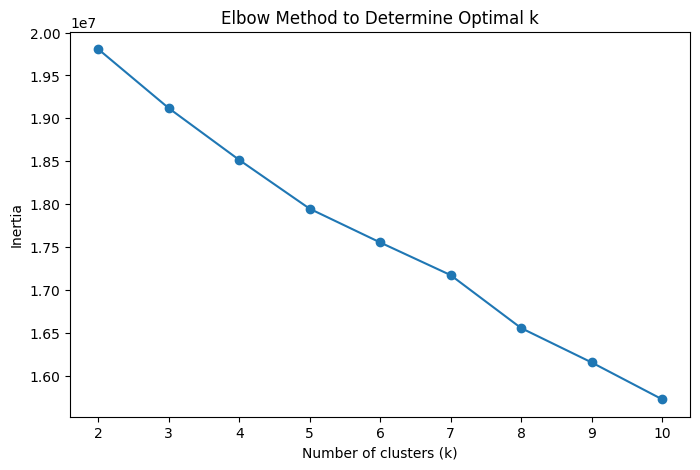

In [19]:
#Elbow Method (Choose Number of Clusters)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia_list = []
K = range(2, 11)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia_list.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia_list, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method to Determine Optimal k")
plt.show()


In [20]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)


# ----------------------------------------------------
# STEP 4: Add cluster numbers to df_clean
# ----------------------------------------------------
df_clean["Cluster"] = cluster_labels


# ----------------------------------------------------
# STEP 5: Add human-readable cluster names
# ----------------------------------------------------
cluster_names = {
    0: "Young Working Families",
    1: "Elderly Retirees",
    2: "High-Income Professionals",
    3: "Middle-Age Moderate Households"
}

df_clean["Cluster_Name"] = df_clean["Cluster"].map(cluster_names)


# ----------------------------------------------------
# STEP 6: Rebuild df_features for prediction
# ----------------------------------------------------
df_features = df_clean.drop(columns=["Cluster", "Cluster_Name"]).copy()

# Save template of model input columns
feature_template = df_features.columns

print("KMeans training completed successfully!")
print(df_clean[["Cluster", "Cluster_Name"]].head())

KMeans training completed successfully!
   Cluster               Cluster_Name
0        2  High-Income Professionals
1        2  High-Income Professionals
2        0     Young Working Families
3        0     Young Working Families
4        0     Young Working Families


In [21]:
df_clean["Cluster_Name"].value_counts()


Cluster_Name
Young Working Families            220156
High-Income Professionals         103588
Middle-Age Moderate Households     78679
Elderly Retirees                   36134
Name: count, dtype: int64

In [22]:
df_clean.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE,EMP_YEARS,INCOME_PER_MEMBER,CHILD_RATIO,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Unknown,OCCUPATION_TYPE_Waiters/barmen staff,Cluster,Cluster_Name
0,0,427500.0,1,1,0,0,2.0,32,12.4,213750.0,0.0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,High-Income Professionals
1,0,427500.0,1,1,0,0,2.0,32,12.4,213750.0,0.0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,High-Income Professionals
2,0,112500.0,1,0,0,0,2.0,58,3.1,56250.0,0.0,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Young Working Families
3,0,270000.0,1,0,1,1,1.0,52,8.4,270000.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Young Working Families
4,0,270000.0,1,0,1,1,1.0,52,8.4,270000.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Young Working Families


In [23]:
# Drop non-numeric columns before groupby mean
temp = df_clean.drop(columns=["Cluster_Name"], errors="ignore")

# Compute mean only on numeric columns
cluster_mean = temp.groupby("Cluster").mean().T

# Display important numeric columns
important_nums = [
    "AGE","AMT_INCOME_TOTAL","EMP_YEARS",
    "CNT_CHILDREN","CNT_FAM_MEMBERS",
    "INCOME_PER_MEMBER","CHILD_RATIO"
]

display(cluster_mean.loc[important_nums])


Cluster,0,1,2,3
AGE,40.650175,40.647147,38.103477,58.749959
AMT_INCOME_TOTAL,175446.122730,200487.373941,233990.191221,154190.889634
EMP_YEARS,7.162027,9.779139,6.357751,0.251724
CNT_CHILDREN,0.513618,0.536005,0.506304,0.032334
CNT_FAM_MEMBERS,2.313446,2.342752,2.261961,1.704572
INCOME_PER_MEMBER,90065.875227,102406.730455,124719.789045,102056.055482
CHILD_RATIO,0.152383,0.158251,0.154936,0.010785


In [24]:
# Select only numeric columns with 0/1 dummy behavior
dummy_cols = [
    c for c in df_clean.select_dtypes(include=["number"]).columns
    if c != "Cluster" and df_clean[c].nunique() <= 2
]

# Compute categorical proportions
cat_props = df_clean.groupby("Cluster")[dummy_cols].mean().T

# Important categorical features to show
important_cats = [
    "CODE_GENDER_M",
    "FLAG_OWN_CAR_Y",
    "FLAG_OWN_REALTY_Y",
    "NAME_EDUCATION_TYPE_Higher education",
    "NAME_INCOME_TYPE_Working",
    "OCCUPATION_TYPE_Managers",
    "OCCUPATION_TYPE_Laborers",
    "OCCUPATION_TYPE_Sales staff",
]

# Show only those that exist
valid_cats = [c for c in important_cats if c in cat_props.index]

display(cat_props.loc[valid_cats])


Cluster,0,1,2,3
CODE_GENDER_M,0.388029,0.290502,0.353352,0.147307
FLAG_OWN_CAR_Y,0.388338,0.379227,0.472584,0.189962
FLAG_OWN_REALTY_Y,0.683488,0.653761,0.676835,0.760876
NAME_EDUCATION_TYPE_Higher education,0.000000,0.438230,0.860920,0.158950
NAME_INCOME_TYPE_Working,0.739439,0.000000,0.602029,0.012062
OCCUPATION_TYPE_Managers,0.056056,0.099906,0.188255,0.000445
OCCUPATION_TYPE_Laborers,0.287582,0.077406,0.116471,0.000826
OCCUPATION_TYPE_Sales staff,0.141254,0.006061,0.093341,0.001424


In [25]:
# -----------------------------------------
# 1. Keep only numeric columns
# -----------------------------------------
numeric_df = df_clean.select_dtypes(include=["number"]).copy()

# -----------------------------------------
# 2. Compute global mean (excluding Cluster)
# -----------------------------------------
global_mean = numeric_df.drop(columns="Cluster").mean()

# -----------------------------------------
# 3. Compute cluster-wise mean
# -----------------------------------------
cluster_mean = numeric_df.groupby("Cluster").mean()

# -----------------------------------------
# 4. Absolute differences — "distinctiveness" score
# -----------------------------------------
diff = (cluster_mean - global_mean).abs()

# -----------------------------------------
# 5. Print top 10 distinguishing features per cluster
# -----------------------------------------
for cl in diff.index:
    print(f"\nTop distinguishing features for Cluster {cl}:")
    print(diff.loc[cl].sort_values(ascending=False).head(10))



Top distinguishing features for Cluster 0:
AMT_INCOME_TOTAL                                     12078.163279
INCOME_PER_MEMBER                                    11353.209457
AGE                                                      2.645394
EMP_YEARS                                                1.214078
NAME_EDUCATION_TYPE_Secondary / secondary special        0.302429
NAME_EDUCATION_TYPE_Higher education                     0.267974
NAME_INCOME_TYPE_Working                                 0.223876
NAME_INCOME_TYPE_Pensioner                               0.171454
OCCUPATION_TYPE_Unknown                                  0.165669
CNT_FAM_MEMBERS                                          0.118981
Name: 0, dtype: float64

Top distinguishing features for Cluster 1:
AMT_INCOME_TOTAL                                     12963.087932
INCOME_PER_MEMBER                                      987.645771
EMP_YEARS                                                3.831190
AGE                           

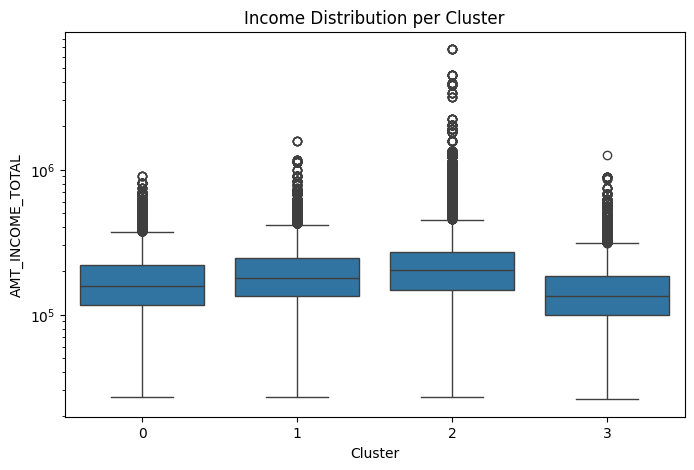

In [26]:
#Visualize how import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x="Cluster", y="AMT_INCOME_TOTAL", data=df_clean)
plt.title("Income Distribution per Cluster")
plt.yscale("log")
plt.show()


In [27]:
#Representative Person from each cluster
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min

# Extract scaled centroids
centroids = kmeans.cluster_centers_

# Get nearest real record to each centroid
closest, _ = pairwise_distances_argmin_min(centroids, X_scaled)

# Show those rows
display(df_clean.iloc[closest])


,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE,EMP_YEARS,INCOME_PER_MEMBER,CHILD_RATIO,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Unknown,OCCUPATION_TYPE_Waiters/barmen staff,Cluster,Cluster_Name
333716,0,202500.0,1,0,0,0,2.0,39,6.5,101250.0,0.0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Young Working Families
275061,0,202500.0,1,0,0,0,2.0,44,14.1,101250.0,0.0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Elderly Retirees
25632,0,225000.0,1,0,0,0,2.0,32,5.4,112500.0,0.0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,High-Income Professionals
153398,0,171000.0,1,0,0,0,2.0,59,0.0,85500.0,0.0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,Middle-Age Moderate Households


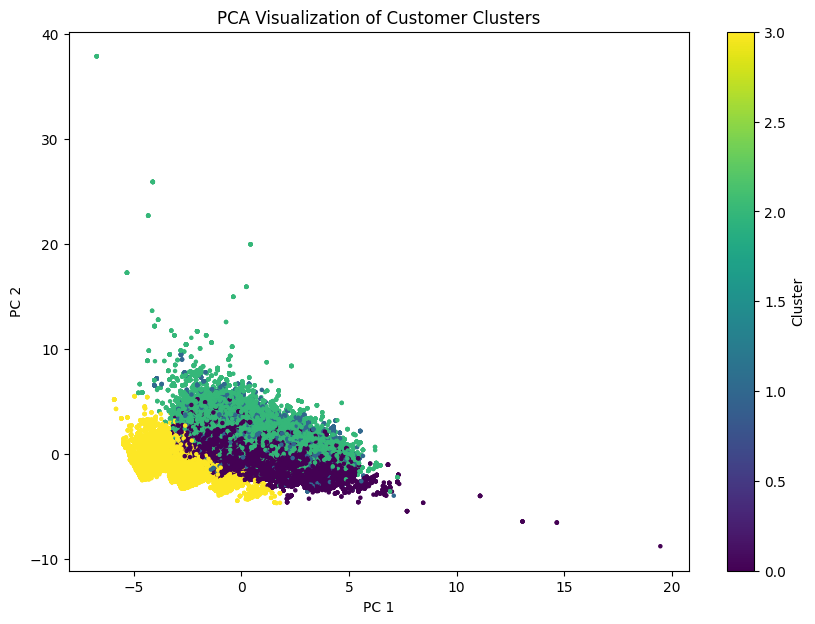

In [28]:
#PCA Visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Reduce scaled data to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# 2. Create a scatterplot of clusters
plt.figure(figsize=(10,7))
plt.scatter(
    pca_components[:, 0],
    pca_components[:, 1],
    c=df_clean["Cluster"],
    cmap='viridis',
    s=5
)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA Visualization of Customer Clusters")
plt.colorbar(label="Cluster")
plt.show()


In [29]:
#Create feature template
feature_template = df_clean.drop(columns=["Cluster", "Cluster_Name"]).columns



In [30]:
#Reusable function using df_clean
def predict_cluster(new_data, feature_template, scaler, kmeans):
    """
    Predict cluster for a new customer using the same preprocessing as df_clean.
    
    new_data: dict or DataFrame with raw input values.
    feature_template: list of columns used in the trained model.
    scaler: fitted StandardScaler.
    kmeans: trained KMeans model.
    """
    
    import pandas as pd
    import numpy as np
    
    # Convert dict → DataFrame
    if isinstance(new_data, dict):
        new_df = pd.DataFrame([new_data])
    else:
        new_df = new_data.copy()

    # ------------------------------------
    # 1. One-hot encode new data
    # ------------------------------------
    new_df = pd.get_dummies(new_df)

    # ------------------------------------
    # 2. Add missing columns (required!)
    # ------------------------------------
    for col in feature_template:
        if col not in new_df.columns:
            new_df[col] = 0

    # ------------------------------------
    # 3. Ensure same column order
    # ------------------------------------
    new_df = new_df[feature_template]

    # ------------------------------------
    # 4. Convert bool → int (if any)
    # ------------------------------------
    bool_cols = new_df.select_dtypes(include=["bool"]).columns
    new_df[bool_cols] = new_df[bool_cols].astype(int)

    # ------------------------------------
    # ⭐ 5. Ensure all data is numeric (important!)
    # ------------------------------------
    new_df = new_df.apply(pd.to_numeric, errors="coerce").fillna(0)

    # ------------------------------------
    # 6. Scale numeric columns
    # ------------------------------------
    scaled_input = scaler.transform(new_df)

    # ------------------------------------
    # 7. Predict cluster
    # ------------------------------------
    cluster = kmeans.predict(scaled_input)[0]

    return cluster


In [31]:
new_customer = {
    "CNT_CHILDREN": 1,
    "AMT_INCOME_TOTAL": 180000,
    "FLAG_MOBIL": 1,
    "FLAG_WORK_PHONE": 0,
    "FLAG_PHONE": 1,
    "FLAG_EMAIL": 0,
    "CNT_FAM_MEMBERS": 3,
    "AGE": 35,
    "EMP_YEARS": 5,
    "INCOME_PER_MEMBER": 60000,
    "CHILD_RATIO": 0.33,
    "CODE_GENDER_M": 0,
    "FLAG_OWN_CAR_Y": 1,
    "FLAG_OWN_REALTY_Y": 1,
    "NAME_INCOME_TYPE_Working": 1,
    "NAME_EDUCATION_TYPE_Higher education": 1,
    "NAME_FAMILY_STATUS_Married": 1,
    "NAME_HOUSING_TYPE_House / apartment": 1,
    "OCCUPATION_TYPE_Managers": 0
}


In [32]:
cluster_number = predict_cluster(new_customer, feature_template, scaler, kmeans)
print("Cluster number =", cluster_number)

cluster_names = {
    0: "Young Working Families",
    1: "Elderly Retirees",
    2: "High-Income Professionals",
    3: "Middle-Age Moderate Households"
}

print("Cluster name:", cluster_names[int(cluster_number)])



Cluster number = 2
Cluster name: High-Income Professionals


In [33]:
df_clean.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE,EMP_YEARS,INCOME_PER_MEMBER,CHILD_RATIO,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Unknown,OCCUPATION_TYPE_Waiters/barmen staff,Cluster,Cluster_Name
0,0,427500.0,1,1,0,0,2.0,32,12.4,213750.0,0.0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,High-Income Professionals
1,0,427500.0,1,1,0,0,2.0,32,12.4,213750.0,0.0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,High-Income Professionals
2,0,112500.0,1,0,0,0,2.0,58,3.1,56250.0,0.0,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Young Working Families
3,0,270000.0,1,0,1,1,1.0,52,8.4,270000.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Young Working Families
4,0,270000.0,1,0,1,1,1.0,52,8.4,270000.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Young Working Families


In [34]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 51 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   CNT_CHILDREN                                       438557 non-null  int64  
 1   AMT_INCOME_TOTAL                                   438557 non-null  float64
 2   FLAG_MOBIL                                         438557 non-null  int64  
 3   FLAG_WORK_PHONE                                    438557 non-null  int64  
 4   FLAG_PHONE                                         438557 non-null  int64  
 5   FLAG_EMAIL                                         438557 non-null  int64  
 6   CNT_FAM_MEMBERS                                    438557 non-null  float64
 7   AGE                                                438557 non-null  int64  
 8   EMP_YEARS                                          438557 non-null  float6